# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Nguyễn Thanh Bình
- MSSV: 21127232
- Lớp: 21CLC10

# Import

In [1123]:
import pandas as pd
import numpy as np
# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp

# Đọc dữ liệu

In [1124]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [1125]:
# Cài đặt các hàm cần thiết ở đây
# Class phục vụ cho việc tính toán mô hình Linear Regression bằng phương pháp OLS
class OLSLinearRegression:
    def fit(self, X, y):
        X_np = addOnesColumn(X)
        y_np = np.array(y)
        X_pinv = np.matmul(np.linalg.inv(np.matmul(X_np.T, X_np)), X_np.T)
        self.w = np.matmul(X_pinv, y_np)
        return self
    
    def get_params(self):
        np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
        return self.w
    
    def predict(self, X):
        X_np = addOnesColumn(np.array(X))
        return np.sum(self.w.ravel() * X_np, axis=1)

# Class lưu trữ các thuộc tính và hàm cho quá trình K-cross validation  
class KFoldCrossValidation:
    def __init__(self, k, folds, models):
        self.k = k
        self.folds = folds
        self.models = models
        self.model_names = [get_model_name(model) for model in models]
        self.mae_values = dict.fromkeys(self.model_names, 0)
        
    def fit(self):
        for fold in self.folds:
            for model in self.models:
                X = fold[model]
                y = fold[['Salary']]
                lr = OLSLinearRegression().fit(X, y)
                y_hat = lr.predict(X)
                mae_value = mae(y_hat, y)
                self.mae_values[get_model_name(model)] += mae_value
    
    def calc_avg_mae(self):
        for model_name in self.model_names:
            self.mae_values[model_name] /= self.k
            
    def get_mae_values(self):  
        self.calc_avg_mae()
        mae_results = []
        for model_name in self.model_names:
            mae_results.append([model_name, self.mae_values[model_name]])
        return pd.DataFrame(mae_results, columns=['Model', 'MAE'])
        
    def get_best_model(self):
        return min(self.mae_values, key=lambda model_name: self.mae_values[model_name])
    # https://stackoverflow.com/questions/3282823/get-the-key-corresponding-to-the-minimum-value-within-a-dictionary

# Các hàm phụ trợ
# Hàm thêm cột 1 phía trước cho hệ số tự do
def addOnesColumn(X):
    return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

# Hàm suffle và chia dataframe thành k folds
def split_data_into_k_folds(data_frame, k, models):
    df = data_frame.copy(deep=True)
    folds = []
    n = len(data_frame)
    m = np.round(n / k)
    # Shuffle dữ liệu 
    df = df.sample(frac=1)
    models_temp = np.array(cp.deepcopy(models))
    models_temp = list(set(np.concatenate(models_temp).flat))
    # Chia dữ liệu thành k folds
    for i in range(k):
        folds.append(df.iloc[int(i*m):int(min(i*m+m, n))][models_temp + ['Salary']])
    return folds

# Hàm lấy tên model dựa trên các models
def get_model_name(model):
    if(len(model) > 1):   
        return ', '.join(model)
    return model[0]

# Hàm tính toán độ lỗi tuyệt đối trung bình (MAE - Mean Absolute Error)
def mae(y, y_hat):
    return np.mean(np.abs(np.array(y).ravel() - np.array(y_hat).ravel()))

# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [1126]:
# Phần code cho yêu cầu 1a
# Lấy ra 11 đặc trưng đầu tiên từ dataframe ban đầu
X_train_1a = cp.deepcopy(X_train).iloc[:,:11]

# Tính toán mô hình cho 11 đặc trưng đầu tiên
lr_1a = OLSLinearRegression().fit(X_train_1a, y_train)
lr_1a.get_params()

array([49248.090, -23183.330, 702.767, 1259.019, -99570.608, 18369.962,
       1297.532, -8836.727, 141.760, 145.742, 114.643, 34955.750])

In [1127]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
X_test_1a = X_test.iloc[:,:11]

y_hat_1a = lr_1a.predict(X_test_1a)
print("MAE: ", mae(y_hat_1a, y_test))

MAE:  105052.5297882299


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 49248.09 - 23183.33*\text{Gender} + 702.767*\text{10percentage} + 1259.019*\text{12percentage} \\
- 99570.608*\text{CollegeTier} + 18369.962*\text{Degree} + 1297.532*\text{collegeGPA} \\
- 8836.727*\text{CollegeCityTier} + 141.76*\text{English} + 145.742*\text{Logical} \\
+ 114.643*\text{Quant} + 34955.75*\text{Domain}$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [1128]:
# Phần code cho yêu cầu 1b
# Khai báo các đặc trưng được sử dụng và số lượng fold (k = 5)
models_1b = [['conscientiousness'], ['agreeableness'], ['extraversion'], ['nueroticism'], ['openess_to_experience']]
k_1b = 5

# Shuffle và chia dữ liệu ban đầu thành 5 folds, mỗi fold chứa các cột là các đặc trưng và Salary
folds_1b = split_data_into_k_folds(train, k_1b, models_1b)
k_cross_validation_1b = KFoldCrossValidation(k_1b, folds_1b, models_1b)
k_cross_validation_1b.fit()

# Tìm ra đặc trưng tốt nhất
best_personality_feature_model = k_cross_validation_1b.get_best_model()
print("Best feature: ", best_personality_feature_model)

# In ra các kết quả cross-validation như yêu cầu
k_cross_validation_1b.get_mae_values()

Best feature:  nueroticism


,Model,MAE
0,conscientiousness,124826.860411
1,agreeableness,123660.699932
2,extraversion,124487.685350
3,nueroticism,123431.019022
4,openess_to_experience,124249.143397


In [1129]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_1b = cp.deepcopy(X_train)[[best_personality_feature_model]]

lr_1b = OLSLinearRegression().fit(X_train_1b, y_train)
lr_1b.get_params()

array([304647.553, -16021.494])

In [1130]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
X_test_1b = X_test[[best_personality_feature_model]]

y_hat_1b = lr_1b.predict(X_test_1b)
print("MAE of best_personality_feature_model: ", mae(y_hat_1b, y_test))

MAE of best_personality_feature_model:  119361.91739987818


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 304647.553 - 16021.494 * \text{nueroticism}$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [1131]:
# Phần code cho yêu cầu 1c
# Khai báo các đặc trưng được sử dụng và số lượng fold (k = 5)
features_1c = [['English'], ['Logical'], ['Quant']]
k_1c = 5

# Shuffle và chia dữ liệu ban đầu thành 5 folds, mỗi folds chứa các cột là các đặc trưng và Salary
folds_1c = split_data_into_k_folds(train, k_1c, features_1c)
k_cross_validation_1c = KFoldCrossValidation(k_1c, folds_1c, features_1c)
k_cross_validation_1c.fit()

# Tìm ra đặc trưng tốt nhất
best_skill_feature_model = k_cross_validation_1c.get_best_model()
print("Best feature: ", best_skill_feature_model)

# In ra các kết quả cross-validation như yêu cầu
k_cross_validation_1c.get_mae_values()

Best feature:  Quant


,Model,MAE
0,English,120393.927793
1,Logical,120176.376853
2,Quant,117163.232942


In [1132]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_1c = cp.deepcopy(X_train)[[best_skill_feature_model]]

lr_1c = OLSLinearRegression().fit(X_train_1c, y_train)
lr_1c.get_params()

array([117759.729, 368.852])

In [1133]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model
X_test_1c = X_test[[best_skill_feature_model]]

y_hat_1c = lr_1c.predict(X_test_1c)
print("MAE of best_skill_feature_model:", mae(y_hat_1c, y_test))

MAE of best_skill_feature_model: 108814.05968837201


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 117759.729 + 368.852 * \text{Quant}$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

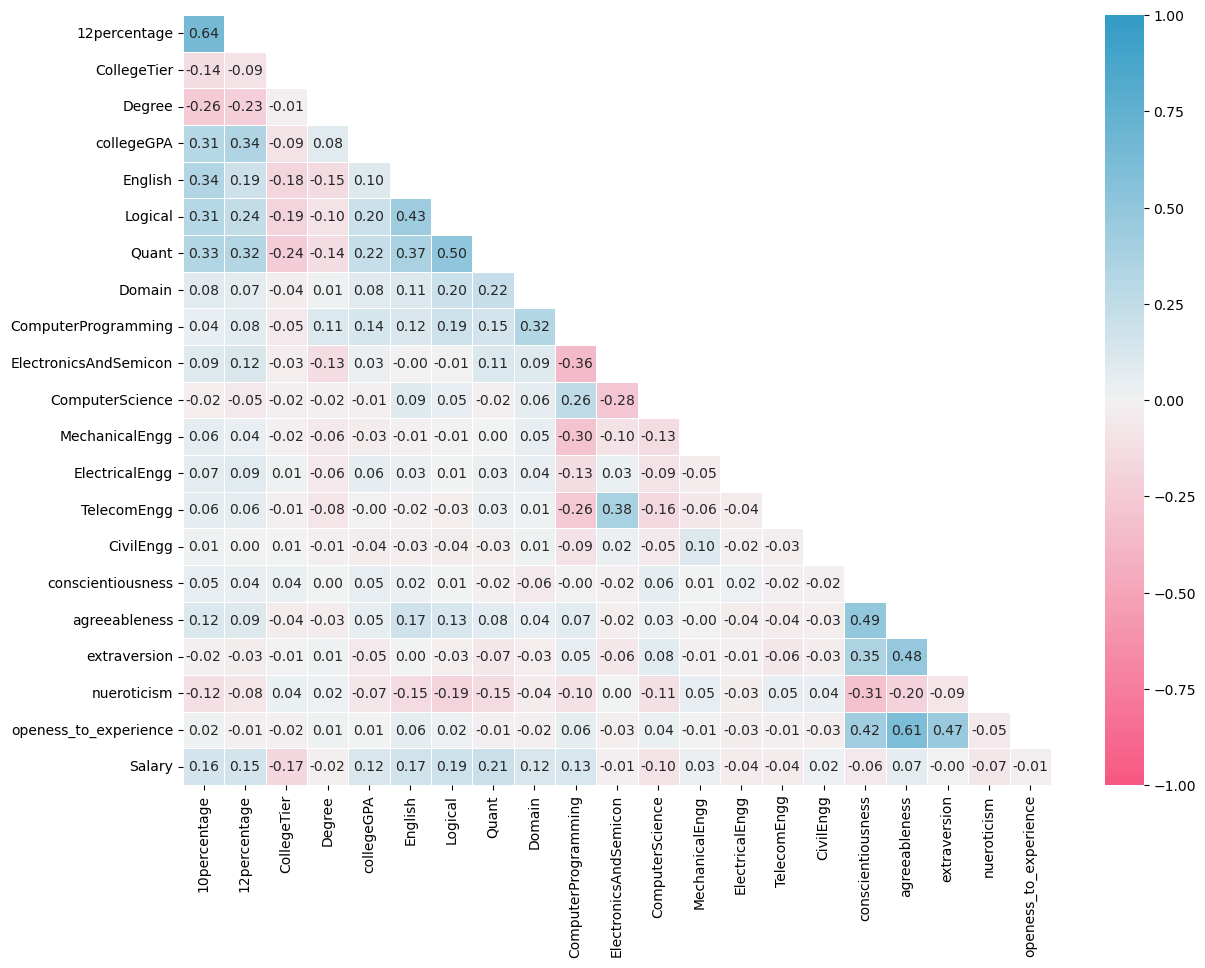

In [1134]:
# Trình bày các phần tìm ra mô hình
# Loại bỏ một vài đặc trưng không liên quan 
train_1d = train.drop(columns=['Gender', 'CollegeCityTier'], axis=1)
# Trực quan hóa dữ liệu bằng Seaborn, dùng hàm corr() để tính toán sự tương quan giữa các dữ liệu, vẽ biểu đồ Heatmap để thấy rõ được sự tương quan giữa Salary và các Features
train_corr = train_1d.corr()
ones_corr = np.ones_like(train_corr, dtype=bool)
mask = np.triu(ones_corr)
train_corr = train_corr.iloc[1:, :-1]
mask = mask[1:, :-1]
fig, ax = plt.subplots(figsize=(14, 10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(data=train_corr, mask=mask, annot=True, fmt=".2f", cmap=cmap, linecolor='white', linewidths=0.5, vmax=1, vmin=-1);

In [1135]:
# Dựa vào biểu đồ heatmap ở trên (dòng cuối cùng), chọn ra các đặc trưng có độ tương quan lớn nhất với Salary để xây dựng mô hình. Ví dụ như Quant: 0.21, Logical: 0.19, ...
# Xây dựng các mô hình chứa các đặc trưng có độ tương quan lớn nhất với số lượng đặc trưng của mỗi mô hình là khác nhau
features_1d = []
# Mô hình 1: 9 đặc trưng
features_1d.append(["Quant", "Logical", "English", "CollegeTier", "10percentage", "12percentage", "ComputerProgramming", "collegeGPA", "Domain"])
# Mô hình 2: 8 đặc trưng 
features_1d.append(["Quant", "English", "CollegeTier", "10percentage", "12percentage", "ComputerProgramming", "collegeGPA", "Domain"])
# Mô hình 3: 7 đặc trưng
features_1d.append(["Quant", "English", "CollegeTier", "12percentage", "ComputerProgramming", "collegeGPA", "Domain"])

## Thử nghiệm, so sánh các mô hình

In [1136]:
# Phần code cho yêu cầu 1d
k_1d = 5
# Shuffle và chia dữ liệu ban đầu thành 5 folds, mỗi folds chứa các cột là các đặc trưng và Salary
folds_1d = split_data_into_k_folds(train, k_1d, features_1d)
k_cross_validation_1d = KFoldCrossValidation(k_1d, folds_1d, features_1d)
k_cross_validation_1d.fit()

# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
my_best_model = k_cross_validation_1d.get_best_model()
print("My best model: ", my_best_model)

# In ra các kết quả cross-validation như yêu cầu
k_cross_validation_1d.get_mae_values()

My best model:  Quant, English, CollegeTier, 10percentage, 12percentage, ComputerProgramming, collegeGPA, Domain


/var/folders/7g/zn94w7qn60s5trhv38lscwrw0000gn/T/ipykernel_32975/1967024633.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  models_temp = np.array(cp.deepcopy(models))


,Model,MAE
0,"Quant, Logical, English, CollegeTier, 10percen...",113771.337064
1,"Quant, English, CollegeTier, 10percentage, 12p...",113332.933863
2,"Quant, English, CollegeTier, 12percentage, Com...",113502.576909


In [1137]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
X_train_1d = cp.deepcopy(X_train)[my_best_model.split(', ')]

lr_1d = OLSLinearRegression().fit(X_train_1d, y_train)
np.round(lr_1d.get_params(), 2)

array([86401.590, 160.650, 160.980, -101319.000, 653.340, 1052.560,
       73.950, 1169.590, 27517.570])

In [1138]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
X_test_1d = X_test[my_best_model.split(', ')]

y_hat_1d = lr_1d.predict(X_test_1d)
print("MAE of my_best_model: ", mae(y_hat_1d, y_test))

MAE of my_best_model:  103953.05306171218


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 86401.590 + 160.650* \text{Quant} + 160.980* \text{English} \\
- 101319.000 * \text{CollegeTier} + 653.340 * \text{10percentage} + 1052.560* \text{12percentage} \\
+ 73.950 * \text{ComputerProgramming} + 1169.590 * \text{collegeGPA} + 27517.570* \text{Domain} $$